In [1]:
using Gadfly
using ColorBrewer
using DataFrames

In [2]:
df = readtable("../data/bigiron_scan_rep_space_a496065_clean.csv");

In [3]:
grouped_info = by(df, [:method, :measure, :genetype, :screen, :representation, :bottleneck_representation, :seq_depth, :crisprtype]) do grouped_df
    n = size(grouped_df, 1)
    mean_score = clamp(mean(grouped_df[:score]), 0, 1)
    std_score = std(grouped_df[:score])
    conf_int = 1.96 * std_score./sqrt(n)
    DataFrame(
        std_score = std_score,
        mean_score = mean_score,
        score_max = mean_score + conf_int,
        score_min = mean_score - conf_int,
        n = n
    )
end
rename!(grouped_info, Dict(:representation => :transfection_representation,
:seq_depth => :sequencing_representation))
n_steps = length(unique(grouped_info[:transfection_representation]))
rep_vals = hcat(map(x->round(Int64, x), logspace(0,4,n_steps)), logspace(0, 4, n_steps))
for repcol in [:transfection_representation, :bottleneck_representation, :sequencing_representation]
    arr = zeros(size(grouped_info, 1))
    for i in 1:size(rep_vals, 1)
        arr[grouped_info[repcol] .== rep_vals[i, 1]] = rep_vals[i, 2]
    end
    grouped_info[repcol] = arr
end
head(grouped_info)

,method,measure,genetype,screen,transfection_representation,bottleneck_representation,sequencing_representation,crisprtype,std_score,mean_score,score_max,score_min,n
1,auprc,dec,all,FacsScreen,1.0,1.0,1.0,CRISPRKO,0.04608391290455255,0.18599032665579845,0.21455343179695596,0.15742722151464095,10
2,auprc,dec,all,FacsScreen,1.0,1.0,1.0,CRISPRi,0.04207112470955607,0.20149441434864723,0.2275703675988559,0.17541846109843856,10
3,auprc,dec,all,FacsScreen,1.0,1.0,2.154434690031884,CRISPRKO,0.04277382857145645,0.17882652444772412,0.2053380180638763,0.15231503083157194,10
4,auprc,dec,all,FacsScreen,1.0,1.0,2.154434690031884,CRISPRi,0.05941812919789614,0.28650094931424874,0.3233286873382638,0.24967321129023368,10
5,auprc,dec,all,FacsScreen,1.0,1.0,4.641588833612778,CRISPRKO,0.04088895860236218,0.19290118847436327,0.21824442758017998,0.16755794936854657,10
6,auprc,dec,all,FacsScreen,1.0,1.0,4.641588833612778,CRISPRi,0.06897681157999591,0.27778119196349393,0.3205334627079906,0.23502892121899727,10


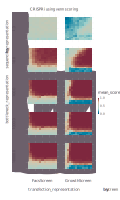

In [4]:
selection = [(:genetype, "all"), (:method, "venn"), (:measure, "incdec"), (:crisprtype, "CRISPRi")]
data = grouped_info[vec(all(hcat([(grouped_info[item[1]] .== item[2]) for item in selection]...), 2)), :];
data = vcat([data[data[:sequencing_representation] .== seq_depth, :] for seq_depth in [1.0, 10.0, 100.0, 1000.0, 10000.0]]...)
data[!isfinite(data[:mean_score]), :mean_score] = 0.0

p = plot(data, ygroup=:sequencing_representation, xgroup=:screen, x=:transfection_representation, 
y=:bottleneck_representation, color=:mean_score, Geom.subplot_grid(Geom.rectbin,
Coord.cartesian(xmin=0, xmax=4, ymin=0, ymax=4)),
Scale.x_log10, Scale.y_log10, Scale.color_continuous(),
Guide.title("$(unique(data[:crisprtype])[1]) using $(unique(data[:method])[1]) scoring"))
draw(SVG("../plots/scan_rep_space.svg", 12cm, 20cm), p)
draw(SVG(12cm, 20cm), p)

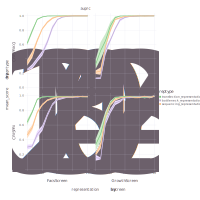

In [5]:
selection = Tuple{Symbol, Any}[
    (:genetype, "all"), 
    (:method, "auprc"), 
    (:measure, "incdec"), 
]
colors = palette("Accent", 4)
reps = [:transfection_representation, :bottleneck_representation, :sequencing_representation]
datas = []
for reptype in combinations(reps, 2)
    push!(selection, (reptype[1], 10^4))
    push!(selection, (reptype[2], 10^4))
    data = grouped_info[vec(all(hcat([(grouped_info[item[1]] .== item[2]) for item in selection]...), 2)), :]
    colname = pop!(setdiff(Set(reps), Set(reptype)))
    data[:reptype] = colname
    data[:representation] = data[colname]
    push!(datas, data)
    pop!(selection)
    pop!(selection)
end
datas = vcat(datas...)
p = plot(datas, xgroup=:screen, ygroup=:crisprtype, x=:representation, 
y=:mean_score, ymax=:score_max, ymin=:score_min,
color=:reptype, Scale.x_log10, Geom.subplot_grid(Geom.line, Geom.ribbon, 
Guide.yticks(ticks=collect(0:0.2:1)), Coord.cartesian(ymax=1.0, ymin=0.0)),
Scale.color_discrete_manual(colors[1:3]..., levels=reps),
Theme(line_width=2pt), Guide.title("$(unique(datas[:method])[1])"))
draw(SVG("../plots/scan_rep_space_line.svg", 20cm, 20cm), p)
draw(SVG(20cm, 20cm), p)